In [1]:
from pyclarify import ClarifyClient, query, SignalInfo, DataFrame
import matplotlib.pyplot as plt

In [2]:
client = ClarifyClient("./credentials_ow_persistence.json")

response = client.select_items(include_dataframe=False)
item_dict = response.result.items
for item_id, meta_data in item_dict.items():
  print(f"ID: {item_id} \t Name: {meta_data.name}")

ID: c983nc7qfsjfsngo9qe0 	 Name: Average Wind Speed
ID: c983nc7qfsjfsngo9qeg 	 Name: NASDAQ SUP3_4
ID: c983nc7qfsjfsngo9qf0 	 Name: NASDAQ SUP4_5
ID: c983nc7qfsjfsngo9qfg 	 Name: NASDAQ SUP5_6
ID: c983nc7qfsjfsngo9qg0 	 Name: Sun State
ID: c983nc7qfsjfsngo9qgg 	 Name: Moon State
ID: c983nc7qfsjfsngo9qh0 	 Name: Wind Speed
ID: c983nc7qfsjfsngo9qhg 	 Name: Air Temperature
ID: c983nc7qfsjfsngo9qi0 	 Name: Sea Temperature
ID: c983nc7qfsjfsngo9qig 	 Name: Has In Feed Treatment 


In [3]:
item_id = ["ca8dhakpllnee2k58qfg"]

filter = query.Filter(fields={"id": query.In(value=item_id)})
response_unfiltered = client.select_items(
    filter = filter,
    include_metadata = True,
    include_dataframe = True,
    not_before = "2022-07-01T00:00:00Z",
    before = "2022-07-10T12:00:00Z"
)
print(response_unfiltered.result.data.times[-1])
# the data (at least for this item) is available with a lag of only two hours

2022-07-08 13:56:57+00:00


In [5]:
response_filtered = client.select_items(
    filter = filter,
    include_metadata = True,
    include_dataframe = True,
    not_before = "2019-05-01T00:00:00Z",
    before = "2022-07-10T12:00:00Z",
    rollup = "P7DT"
)
# question: is the time tag that comes out of the rollup the center of the window?

st3m_langoey = response_filtered.result.data.to_pandas()
print(st3m_langoey.index[-10:])

DatetimeIndex(['2022-05-02 00:00:00+00:00', '2022-05-09 00:00:00+00:00',
               '2022-05-16 00:00:00+00:00', '2022-05-23 00:00:00+00:00',
               '2022-05-30 00:00:00+00:00', '2022-06-06 00:00:00+00:00',
               '2022-06-13 00:00:00+00:00', '2022-06-20 00:00:00+00:00',
               '2022-06-27 00:00:00+00:00', '2022-07-04 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [4]:
response_filtered_1D = client.select_items(
    filter = filter,
    include_metadata = True,
    include_dataframe = True,
    not_before = "2019-05-01T00:00:00Z",
    before = "2022-07-10T12:00:00Z",
    rollup = "P1DT"
)
# question: is the time tag that comes out of the rollup the center of the window?

st3m_langoey_daily = response_filtered_1D.result.data.to_pandas()
print(st3m_langoey_daily.index[-10:])

DatetimeIndex(['2022-06-29 00:00:00+00:00', '2022-06-30 00:00:00+00:00',
               '2022-07-01 00:00:00+00:00', '2022-07-02 00:00:00+00:00',
               '2022-07-03 00:00:00+00:00', '2022-07-04 00:00:00+00:00',
               '2022-07-05 00:00:00+00:00', '2022-07-06 00:00:00+00:00',
               '2022-07-07 00:00:00+00:00', '2022-07-08 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


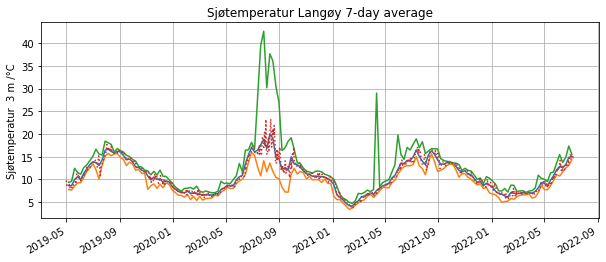

In [6]:
f,ax = plt.subplots(figsize=(10,4))
st3m_langoey.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
st3m_langoey.ca8dhakpllnee2k58qfg_min.plot(ax=ax)
st3m_langoey.ca8dhakpllnee2k58qfg_max.plot(ax=ax)
st3m_langoey_daily.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,ls='dotted')
ax.grid()
ax.set_ylabel('{0:s}  {1:s} /{2:s}'.format(
        response_unfiltered.result.items[item_id[0]].name,
        response_unfiltered.result.items[item_id[0]].labels['depth'][0],
        response_unfiltered.result.items[item_id[0]].engUnit
    )
);
ax.set_title('{0:s} {1:s} 7-day average'.format(
        response_unfiltered.result.items[item_id[0]].name,
        response_unfiltered.result.items[item_id[0]].labels['site'][0]
    )
);

### Compute seasonal cycle

In [7]:
import xarray as xr
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.optimize import leastsq

In [170]:
class seas_cycle():
    """
    seasonal cycle class
    will transform time axis to day of year (thus ignoring hrs, mins, secs!), so no matter what the
    time step is in the data, it will transform them into single day time steps!
    """
    
    def __init__(self,absolute_vals,nharm=3,time_name='time'):
        """
        Initialize a seasonal cycle object.
        Default number of harmonics is 3, which corresponds approximately
        to a low-pass filter with cut-off at 90 days
        """
        self.nharm = nharm
        self.time_name = time_name

        # convert to xarray.Dataset if not already:
        if isinstance(absolute_vals,xr.Dataset):
            self.absolute_vals = absolute_vals
        elif isinstance(absolute_vals,pd.DataFrame):
            self.absolute_vals = pddf2xrds(absolute_vals)
        elif isinstance(absolute_vals,pd.Series):
            self.absolute_vals = pddf2xrds(pd.DataFrame(absolute_vals))
        else:
            print('<absolute_vals> is of unsupported type {0:}, try converting to xarray.Dataset, pandas.DataFrame or pandas.Series first'.format(type(absolute_vals)))

        # group time series by day of year:
        if 'month_day' not in self.absolute_vals.coords:
            self.doy = get_doy_coord(self.absolute_vals)
            self.absolute_vals = self.absolute_vals.assign_coords(month_day=self.doy)
        
        # compute calendar day mean and std as initial estimate of the seasonal cycle
        self.abs_doy_mean = self.absolute_vals.groupby('month_day').mean((time_name))

    def fit(self):
        """
        fit a seasonal cycle to a given time series
        """
        # ,self.offset,self.amplitude,self.phase
        self.mean_sc,self.offset,self.amplitude,self.phase = xr.apply_ufunc(
            seascyc_full,
            self.abs_doy_mean.month_day,
            self.abs_doy_mean,
            self.nharm,
            input_core_dims = [['month_day'],['month_day'],[]],
            output_core_dims = [['month_day'],[],['hrmc'],['hrmc']],
            dask_gufunc_kwargs =  dict(output_sizes = {'hrmc':self.nharm}),
            vectorize = True,
            dask = 'parallelized' # does probably not make a difference atm, could try decorating the seascyc functions with numba
        )

    def predict(self,doy,time_name = 'time'):

        prediction = xr.apply_ufunc(
            construct_clim, # functions
            doy, self.offset,self.amplitude,self.phase, # input
            input_core_dims = [[time_name],[],['hrmc'],['hrmc']],
            output_core_dims = [[time_name],],
            vectorize = True,
            dask = 'parallelized' # does probably not make a difference atm, could try decorating the seascyc functions with numba
        )

        return prediction

    def training_anomalies(self):
        """
        expand the estimated seasonal cycle to have a value on every time stamp of the input
        """
        # expand seasonal cycle to valid dates:
        self.sc_exp_doy = self.predict(self.doy)
        # compute anomalies:
        self.anomalies = self.absolute_vals - self.sc_exp_doy

def seascyc_full(doy,timeseries,harmonics):

    os,a,ph = harm_fit(doy,timeseries,harmonics)
    return construct_clim(doy,os,a,ph),os,a,ph


def harm_fit(doy,timeseries,harmonics):
    """
    obtain a given number of harmonics from a time series
    
    INPUT:
            doy:            (1D np.array) 
            timeseries:     (1D np.array) corresponding time series  
            harmonics:      (list)
    OUTPUT:
            returns offest, amp, phase (int,list,list) where amp and phase have length
            matching the number of requested harmonics 
    """

    offset = timeseries.mean(axis=0)
    ts_centered = timeseries - offset

    # transform doy to coordinate running from -pi to pi
    x = 2*np.pi*(doy - .5)/365 - np.pi
    
    rms = 3.*ts_centered.std()/(2**.5)
    harm_fit_params = []
    for n in range(0,harmonics):
    
        # function to minimize
        opt_func = lambda wv: wv[0] * np.sin(x*(n+1) + wv[1]) - ts_centered
    
        # minimize using least squares:
        harm_fit_params.append(leastsq(opt_func,[rms,0])[0])
    
    amp,phase = np.array(harm_fit_params).T
    
    return offset,amp,phase


def construct_clim(doy,offset,amp,phase):
    """
    construct the climatology from a given number of harmonics
    
    INPUT:
            doy:        (list) 
            offest:     (float) 
            amp:        (list) 
            phase:      (list) 
    OUTPUT:
            np.array of length 'ts_len' 
    """

    timeseries_harmrem = np.zeros([len(doy)])
    # transform doy to coordinate running from -pi to pi
    x = 2*np.pi*(doy - .5)/365 - np.pi

    for n in range(len(amp)):
        timeseries_harmrem += amp[n]*np.sin(x*(n+1) + phase[n])

    return timeseries_harmrem + offset


# transform pandas dataframe to xarray dataarray:
def pddf2xrds(pddf,varn_ls=[]):
    
    if not isinstance(varn_ls,list):
        print('<varn_ls> needs to be passed as list even if only one element should be selected!')
        return

    if pddf.index.name is None:
        pddf.index.name = 'time'

    if varn_ls:
        xrds = xr.Dataset(
            pddf[varn_ls]
        )
    else:
        xrds = xr.Dataset(
            pddf
        )

    return xrds.assign_coords(time=pddf.index.values)

def month_day_to_doy(moda_str_lst):
    """
    return a 1D np.array of days of year that ignore leap years and just place any Feb 29 AND Mar 1
    on day 61, Mar 2 on day 62 etc. Note that this means that a leap year will get TWO days with doy 61!
    Note that doy for Jan 1 is 1!
    INPUT:
            moda_str_lst:   (list) list of strings in the form "MM-DD" (M: month, D: day)
    OUTPUT:
            np.array of the same length as input that contains the day of year for each 
            of the month-day-strings
    """
    doy = []
    dummy_year = 1999
    base_date = datetime(dummy_year-1,12,31)
    for moda_str in moda_str_lst:
        if moda_str == '02-29':
            doy.append(60)
        else:
            doy.append(
                (datetime.strptime('{0:d}-{1:s}'.format(dummy_year,moda_str),'%Y-%m-%d') - base_date).days
            )

    return np.array(doy)

def get_doy_coord(data):
    """
    """

    return xr.DataArray(
        month_day_to_doy(data.time.dt.strftime('%m-%d').values),
        coords=dict(time=(['time'],data['time'].values)),
        dims=('time'),
        name='month_day'
        )

In [171]:
SC = seas_cycle(st3m_langoey.ca8dhakpllnee2k58qfg_avg)
SC.fit()
SC.training_anomalies()

SC_1 = seas_cycle(st3m_langoey_daily.ca8dhakpllnee2k58qfg_avg)
SC_1.fit()
SC_1.training_anomalies()

SC_varharm = seas_cycle(st3m_langoey.ca8dhakpllnee2k58qfg_avg,nharm=1)
SC_varharm.fit()
SC_varharm.training_anomalies()

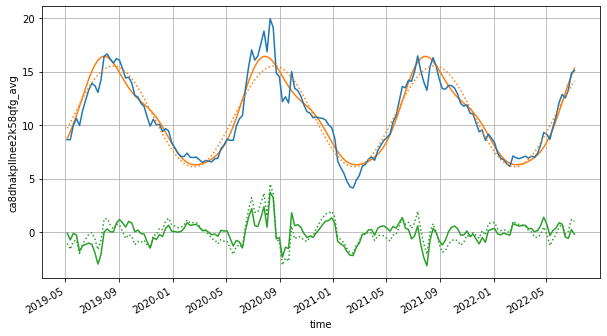

In [172]:
f,ax = plt.subplots(figsize=(10,5))

SC.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C1')
SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C0')
SC.anomalies.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C2')

SC_varharm.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,ls='dotted',color='C1')
# SC_varharm.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,ls='dotted')
SC_varharm.anomalies.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,ls='dotted',color='C2')

ax.grid()

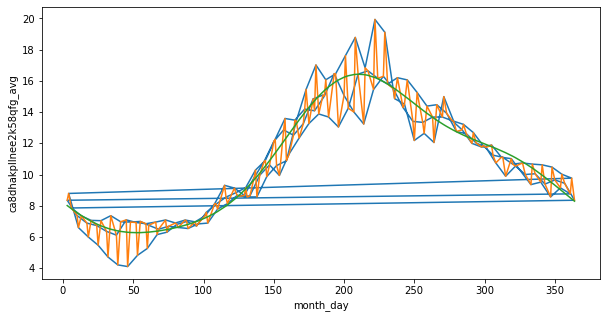

In [173]:
f,ax = plt.subplots(figsize=(10,5))
SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(x='month_day',ax=ax)
SC.abs_doy_mean.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
SC.mean_sc.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
# SC_1.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(x='month_day',ax=ax)
# SC_1.abs_doy_mean.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
# SC_1.mean_sc.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)

### Estimate lagged anomaly correlation ('fit' the model)

Use the anomalies to estimate lag correlations

In [229]:
class persistence():
    def __init__(self,lags=4):
        """
        lags in units of timestep of input data
        """
        self.lags = lags

    def fit(self,timeseries):
        
        self.training_ts = timeseries
        
        corr = xr.apply_ufunc(
            auto_corr,
            self.training_ts,self.lags,
            input_core_dims = [['time'],[]],
            output_core_dims = [['lags'],],
            dask_gufunc_kwargs =  dict(output_sizes = {'lags':self.lags}),
            vectorize = True,
            dask = 'parallelized'
        )

        self.corr = corr.assign_coords(lags=np.arange(1,1+self.lags))

    def predict(self,intial_condition):
        """
        can only handle a single value as initial condition currently
        """
        
        persistence_fc = self.corr * intial_condition
        
        td = [persistence_fc.time.values + pd.Timedelta('{0:d}D'.format(ddiff*7)) for ddiff in persistence_fc.lags.values]
        tdoy = persistence_fc.month_day.values + persistence_fc.lags.values*7
        self.persistence_fc = persistence_fc.assign_coords(dict(time = ('lags',td),time_doy = ('lags',tdoy))).drop('month_day')

        return self.persistence_fc

def auto_corr(timeseries,lags):
    return np.array([np.corrcoef(timeseries[lg:],timeseries[:-lg])[0,1] for lg in range(1,1+lags)])

In [230]:
anom_pers = persistence(lags=4)
anom_pers.fit(SC.anomalies.ca8dhakpllnee2k58qfg_avg)

### Make prediction

In [282]:
# prediction of the anomaly:
anom_pred = anom_pers.predict(SC.anomalies.ca8dhakpllnee2k58qfg_avg.isel(time=-1))

# prediction of seasonal cycle:
sc_pred = SC.predict(anom_pred.time_doy,time_name='lags')

abs_pred = anom_pred + sc_pred

### Plot this

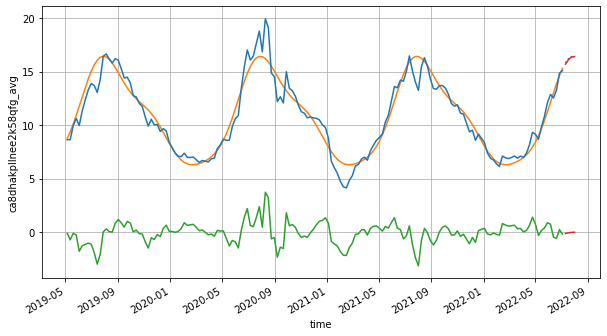

In [283]:
f,ax = plt.subplots(figsize=(10,5))

SC.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C1')
SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C0')
SC.anomalies.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C2')

anom_pred.plot(ax=ax,x='time',color='C3')
sc_pred.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,x='time',color='C4',ls='dotted')
abs_pred.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,x='time',color='C3')

ax.grid()

### Write signal back to clarify

In [327]:
signal_name = '{0:s} forecast'.format(response_filtered.result.items[item_id[0]].name)
signal_desc = 'Persistence forecast of 7-day averages up to 4 weeks ahead'
signal_unit = response_filtered.result.items[item_id[0]].engUnit
signal_labels = {'data-source':['Persistence Model'],'site':response_filtered.result.items[item_id[0]].labels['site'],'depth':response_filtered.result.items[item_id[0]].labels['depth']}

In [337]:
# put forecast values into list:
fc_list = list(abs_pred.ca8dhakpllnee2k58qfg_avg.values)

# make list with corresponding dates:
time_list = list(abs_pred.time.values)

In [339]:
# Create a signal and write metadata to it
signal = SignalInfo(name = signal_name, description = signal_desc, engUnit = signal_unit, labels = signal_labels, sourceType = 'prediction')
client.save_signals(input_ids=['persistence_fc_test'], signals=[signal], create_only=False)
# Write data into a signal
data = DataFrame(series={'persistence_fc_test': fc_list}, times = time_list)
client.insert(data)


Response(jsonrpc='2.0', id='1', result=InsertResponse(signalsByInput={'persistence_fc_test': InsertSummary(id='cb45n4spllneem6kh450', created=False)}), error=None)